# A/B testing workshop

Let's make some necessary imports

In [26]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind_from_stats
warnings.filterwarnings('ignore')

## Functions

Let's define functions which we will use in our workshop

In [4]:
def get_bootstrap_samples(X: np.array = None):
    """
    Returns a sample from an input array with replacement
    Parameters:
    --------------
    X: np.array (default = None)
        numpy array containing input values
    Returns:
    --------------
    sample_X: np.array
        sample from an input array with replacement
    Example usage:
    ---------------
        import numpy as np
        X = np.random.normal(10, 10, 100) #100 element size array from normal distribution
        X_sample = get_bootstrap_samples(X = X) #bootstrap sample from X
    """
    indices = np.random.randint(0, X.shape[0], size=X.shape[0])
    sample_X = X[indices]
    return sample_X

This function allows us to compute type I error. Computation is performed by bootstrap methodology

In [5]:
def check_first_type_error(pilot: np.ndarray = None,
                           control: np.ndarray = None,
                           n_iter: int = 10000,
                           alpha: float = 0.05):
    """
    Calcs a first type error on 2 numpy arrays (pilot/prepilot, prepilot/history, etc)
    Parameters:
    --------------
    pilot: np.ndarray (default = None)
        numpy ndarray containing values for test group
    control: np.ndarray (default = None)
        numpy ndarray containing values for control group
    n_iter: int (default = 10000)
        Number of bootstrap iterations
    alpha: float (default = 0.05)
        Probability of rejecting the null hypothesis when it is true
    ----------------
    Returns:
    alpha_array: python tuple
        Tuple (alpha_empirical_mw, alpha_empirical_tt) calculated values (I type error for MW and TT tests)
    """
    counter_mw = 0
    counter_tt = 0

    mann_res = list()
    ttest_res = list()

    for i in range(n_iter):
        bs_pilot = get_bootstrap_samples(pilot)
        bs_control = get_bootstrap_samples(control)

        pval_mw = mannwhitneyu(bs_pilot.reshape(-1, 1),
                               bs_control.reshape(-1, 1)).pvalue
        mann_res.append(pval_mw)
        pval_tt = ttest_ind_from_stats(bs_pilot.mean(), bs_pilot.std(), bs_pilot.shape[0], bs_control.mean(),
                                       bs_control.std(), bs_control.shape[0], equal_var=False).pvalue
        ttest_res.append(pval_tt)
        if pval_mw < alpha:
            counter_mw += 1
        if pval_tt < alpha:
            counter_tt += 1
    alpha_empirical_mw = counter_mw / n_iter
    alpha_empirical_tt = counter_tt / n_iter
    alpha_array = (alpha_empirical_mw, alpha_empirical_tt)

    return alpha_array

This function allows to compute type II error for different effects.
We can add effect by random normal noise (more preferred) and just multiply values on effect (works fine for data with not-normal distribution)

In [6]:
def check_second_type_error(pilot: np.ndarray=None,
                            control: np.ndarray=None,
                            n_iter=10000,
                            beta=0.05,
                            effects=[0.01, 0.03, 0.05, 0.1],
                            effect_type: str = 'noise'):
    """
    Calcs a first type error on 2 numpy arrays (pilot/prepilot, prepilot/history, etc)
    Parameters:
    ----------------
    pilot: np.ndarray (default = None)
        numpy ndarray containing values for test group
    control: np.ndarray (default = None)
        numpy ndarray containing values for control group
    n_iter: int (default = 10000)
        Number of bootstrap iterations
    beta: float (default = 0.05)
        Probability of rejecting the alternative hypothesis when it is true
    effects: python list (default = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2])
        Possible values for an effect size (we calc II type error for several possible effect sizes)
    --------------------
    Returns:
    beta_array: python tuple
        Tuple (effects, alpha_empirical_mw, alpha_empirical_tt) calculated values (II type errors list for MW and TT tests)
    """
    mw_errors = []
    tt_errors = []
    for effect in effects:
        ttest_res = []
        mann_res = []

        for i in range(n_iter):
            bs_pilot = get_bootstrap_samples(pilot)
            bs_control = get_bootstrap_samples(control)
            if effect_type == 'noise':
                mean_pilot = np.mean(bs_pilot)
                std_pilot = np.std(bs_pilot)
                noise = np.random.normal(
                    mean_pilot*effect, std_pilot / 10, size=len(bs_pilot))

                bs_pilot = bs_pilot + noise
            elif effect_type == 'multiply':
                bs_pilot = (1 + effect) * bs_pilot
            ttest = stats.ttest_ind(bs_pilot, bs_control, equal_var=False)
            mann = stats.mannwhitneyu(bs_pilot, bs_control)

            ttest_res.append(ttest[1])
            mann_res.append(mann[1])

        beta_empirical_tt = (np.array(ttest_res) > beta).mean()
        beta_empirical_mw = (np.array(mann_res) > beta).mean()
        mw_errors.append(beta_empirical_mw)
        tt_errors.append(beta_empirical_tt)

    result_tuple = (effects, mw_errors, tt_errors)
    return result_tuple

In [7]:
def cuped(
    treated: pd.Series,
    covariate: pd.Series
    ) -> pd.Series:
    """CUPED (Controlled-experiment Using Pre-Experiment Data).

    Parameters
    ----------
    treated: pd.Series
        sample which we need to linearize
    covariate: pd.Series
        covariate which used for linearization

    Returns
    -------
    pd.Series
        linearized sample
    """
    if (treated.isna().sum() != 0) or (covariate.isna().sum() != 0):
        raise ValueError("Samples contain NaN")
    theta = np.cov(treated, covariate)[0][1] / np.var(covariate)
    return treated - theta * (covariate - np.mean(covariate))

In [8]:
WORKDIR = './Documents/data/'

### Some data preprocessing

In [32]:
transactions.head()

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo
0,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,004,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.0,146.98,0
1,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,003,90fca68123e692a005a4edeadd94b2f2,12ec64451b8e426db16f3f05ea770901,1.0,249.99,1
2,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,012,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1
3,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,013,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1
4,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,011,90fca68123e692a005a4edeadd94b2f2,571c6d3b559db8445e05265649eb30ab,2.0,53.98,1


In [10]:
transactions = pd.read_parquet(os.path.join(WORKDIR, 'transactions.parquet'))
prepilot = transactions[(transactions['chq_date'] >= '2016-10-05') &
                        (transactions['chq_date'] < '2017-01-05')]
pilot = transactions[(transactions['chq_date'] >= '2017-01-05') &
                     (transactions['chq_date'] < '2017-04-05')]
prepilot = prepilot.groupby('chq_id').agg({'sales_sum': np.sum, 'client_id': 'first'}).reset_index()
pilot = pilot.groupby('chq_id').agg({'sales_sum': np.sum, 'client_id': 'first'}).reset_index()
prepilot = prepilot.groupby('client_id').agg({'sales_sum': np.mean})
pilot = pilot.groupby('client_id').agg({'sales_sum': np.mean})
experiment = (pd.merge(prepilot, 
                       pilot, 
                       how='right', 
                       left_index=True, 
                       right_index=True, 
                       suffixes=('_prepilot', '_pilot'))
              .fillna(0))

In [11]:
test_group = experiment.sample(frac=0.5, random_state=42)
control_group = experiment[~experiment.index.isin(test_group.index)]

In [33]:
test_group.head()

,sales_sum_prepilot,sales_sum_pilot,sales_sum_pilot_cuped,bucket
client_id,,,,
b5a4d8ae72ddb42ae77123fb10fb53d9,2124.500000,4528.000000,3968.687828,1771
30caff3de10c0b7f3aa5752b821757a4,1574.857143,1679.000000,1534.733255,3931
5dfb562dc917a716deecf092455bba7b,365.000000,762.500000,1531.818627,3698
87ca1d59bfe5f4a8631a68d628059baa,433.000000,766.500000,1484.470576,4289
369dfbefb048f438b3dd87dee2f6a3ab,2645.437500,2996.882353,2044.200698,4873


In [12]:
alpha_array = check_first_type_error(pilot=test_group['sales_sum_prepilot'].values,
                                     control=control_group['sales_sum_prepilot'].values, 
                                     n_iter=1000)
print(f'Type I error for T-test: {alpha_array[1]*100}%')
print(f'Type I error for U-test: {alpha_array[0]*100}%')

Type I error for T-test: 4.6%
Type I error for U-test: 11.0%


In [13]:
beta_array_noise = check_second_type_error(pilot=test_group['sales_sum_prepilot'].values,
                                           control=control_group['sales_sum_prepilot'].values, 
                                           n_iter=1000, 
                                           effect_type='noise')

In [14]:
report = pd.DataFrame(beta_array_noise[1:], columns=beta_array_noise[0], index=['t-test', 'mann-whitney'])
report

,0.01,0.03,0.05,0.10
t-test,0.089,0.000,0.0,0.0
mann-whitney,0.611,0.001,0.0,0.0


In [15]:
beta_array_multiply = check_second_type_error(pilot=test_group['sales_sum_prepilot'].values,
                                              control=control_group['sales_sum_prepilot'].values, 
                                              n_iter=1000, 
                                              effect_type='multiply')

In [16]:
report = pd.DataFrame(beta_array_multiply[1:], columns=beta_array_multiply[0], index=['t-test', 'mann-whitney'])
report

,0.01,0.03,0.05,0.10
t-test,0.316,0.0,0.0,0.0
mann-whitney,0.616,0.0,0.0,0.0


In [17]:
test_group['sales_sum_pilot_cuped'] = cuped(treated=test_group['sales_sum_pilot'], 
                                            covariate=test_group['sales_sum_prepilot'])
control_group['sales_sum_pilot_cuped'] = cuped(treated=control_group['sales_sum_pilot'], 
                                               covariate=control_group['sales_sum_prepilot'])

In [18]:
N_BUCKETS = 5000
test_group['bucket'] = np.random.randint(0, N_BUCKETS, size=test_group.shape[0])
bucket_data = test_group.groupby('bucket').agg({'sales_sum_pilot': np.mean})

In [20]:
var_before = test_group['sales_sum_pilot'].var()
var_after_cuped = test_group['sales_sum_pilot_cuped'].var()
var_bucket = bucket_data['sales_sum_pilot'].var()

diff_cuped = 1 - var_after_cuped / var_before
diff_buckets = 1 - var_bucket / var_before
print('Variance before: {:.2f}'.format(var_before))
print('Variance after CUPED: {:.2f}'.format(var_after_cuped))
print('Variance after buckets: {:.2f}'.format(var_bucket))
print('Variance was reduced by buckets on {:.1f}%'.format(diff_buckets*100))
print('Variance was reduced by CUPED on {:.1f}%'.format(diff_cuped*100))

Variance before: 2132784.00
Variance after CUPED: 1324605.05
Variance after buckets: 276999.38
Variance was reduced by buckets on 87.0%
Variance was reduced by CUPED on 37.9%


In [22]:
pval_tt = ttest_ind_from_stats(test_group['sales_sum_pilot_cuped'].mean(), 
                               test_group['sales_sum_pilot_cuped'].std(), 
                               test_group.shape[0], 
                               control_group['sales_sum_pilot_cuped'].mean(),
                               control_group['sales_sum_pilot_cuped'].std(), 
                               control_group.shape[0], 
                               equal_var=False).pvalue
print('P-value: {:.2f}'.format(pval_tt))

P-value: 0.88


In [28]:
def calc_bootstrap_effect(pilot: np.ndarray,
                          control: np.ndarray,
                          n_iter: int = 1000,
                          alpha: float = 0.05):
    effects_array = []
    for _ in range(n_iter):
        bs_pilot = get_bootstrap_samples(pilot)
        bs_control = get_bootstrap_samples(control)
        effect = np.mean(bs_pilot) / np.mean(bs_control) - 1.0
        effects_array.append(effect)
    return effects_array

In [29]:
effects = calc_bootstrap_effect(test_group['sales_sum_pilot'], control_group['sales_sum_pilot'])

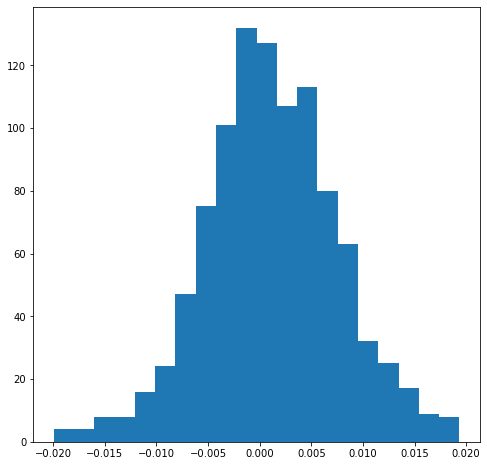

In [31]:
plt.figure(figsize=(8, 8))
plt.hist(effects, bins=20);